In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable
import seaborn as sns

import pickle

from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification

In [2]:
n_vals = [int(val) for val in [1e3, 1e4, 1e5]]
p_vals = [int(val) for val in [1e2, 3e2, 1e3]]

#
# Things that are common between plots
#
methods = ['RATE', 'RF-mimic-gini-noCV', 'RF-mimic-gini-withCV',
           'GBM-mimic-gini-noCV', 'GBM-mimic-gini-withCV', 'Pixel-corr',]
colours = dict(zip(methods, ["red", "purple", "hotpink", "navy", "blue", "orange"]))

legend_labels = dict(zip(methods, ["RATE", "RF mimic (no CV)", "RF mimic (with CV)",
                                   "GBM mimic (no CV)", "GBM mimic (with CV)", "Correlation",]))
markers = dict(zip(methods, ["o"] + ["," for _ in range(len(methods)-1)]))

base_fpr = np.linspace(0, 1, 101) # Interpolate fpr (x-axis) at these locations

ribbon_alpha = 0.2

In [3]:
# Load data
with open("simstudy_data.pkl", "rb") as f:
    result_dict = pickle.load(f)

# Figure 2

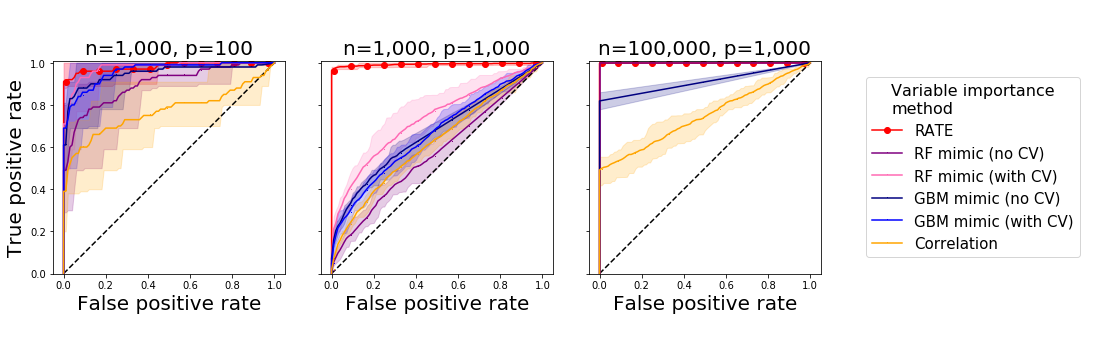

In [5]:
plotsize = 5
fontsize = 20

upper_qile, lower_qile = 0.9, 0.1

included_methods = methods

included_keys = [(1000, 100), (1000, 1000), (100000, 1000)]

fig, axes = plt.subplots(1, len(included_keys)+1, sharey=True, figsize=(len(included_keys)*plotsize+0.5, plotsize))

for i, (n, p) in enumerate(included_keys):
    axes[i].set_title("n={:,}, p={:,}".format(n, p), fontsize=fontsize)
    if i <= len(included_keys):
        axes[i].set_aspect("equal")
        axes[i].set_xlabel("False positive rate", fontsize=fontsize)
        axes[i].plot([0,1], [0,1], c="black", linestyle="--")
        p_informative = int(0.1*p)
        labels = np.hstack([np.ones(p_informative), np.zeros(p-p_informative)])
        if (n,p) not in result_dict:
            continue
        for m in included_methods:
            k = (n,p)
            if m not in result_dict[k]:
                continue
            curves, interp_tpr, aucs = [], [], []
            for rep in range(len(result_dict[k][m])):
                tpr, fpr, _ = roc_curve(labels, np.abs(result_dict[k][m][rep]))
                tpr[0] = 0.0
                curves.append([tpr, fpr])
                interp_tpr.append(np.interp(base_fpr, curves[-1][0], curves[-1][1]))
                aucs.append(auc(curves[-1][0], curves[-1][1]))

            # So that (0,0) is the first point on the ROC curve
            interp_tpr = [np.hstack([[0.0], tpr]) for tpr in interp_tpr]
            mean_interp_tpr = np.mean(interp_tpr, axis=0)
            tpr_qile_upp = np.quantile(interp_tpr, upper_qile, axis=0)
            tpr_qile_low = np.quantile(interp_tpr, lower_qile, axis=0)
            
            axes[i].plot(np.hstack([[0], base_fpr]), mean_interp_tpr,
                c=colours[m],
                label=legend_labels[m])
            axes[i].plot(base_fpr[1::8], mean_interp_tpr[1::8], ls="",
                c=colours[m], marker=markers[m],
                label=legend_labels[m])
            axes[i].fill_between(np.hstack([[0], base_fpr]), tpr_qile_low, tpr_qile_upp,
                                 color=colours[m], alpha=ribbon_alpha)
            axes[i].set_ylim([0,1.01])

        
axes[0].set_ylabel("True positive rate", fontsize=fontsize)

# Legend
legend_elements = [Line2D([], [], c=colours[m], marker=markers[m],
                         label=legend_labels[m], alpha=1.0) for m in included_methods]

leg_title = "Variable importance\nmethod"
#borderpad = plt.rcParams["legend.borderpad"] if i==0 else 1.0
legend = axes[3].legend(handles=legend_elements, loc='center',
           ncol=1, fancybox=True, title=leg_title, 
               fontsize=fontsize-5)
legend.get_title().set_fontsize(fontsize-4)
axes[3].axis('off')

plt.tight_layout()

# Supplementary figure (S2)

n= 1000 p= 100
n= 1000 p= 300
n= 1000 p= 1000
n= 10000 p= 100
n= 10000 p= 300
n= 10000 p= 1000
n= 100000 p= 100
Skipping RF-mimic-gini-withCV
Skipping GBM-mimic-gini-withCV
n= 100000 p= 300
Skipping RF-mimic-gini-withCV
Skipping GBM-mimic-gini-withCV
n= 100000 p= 1000
Skipping RF-mimic-gini-withCV
Skipping GBM-mimic-gini-withCV


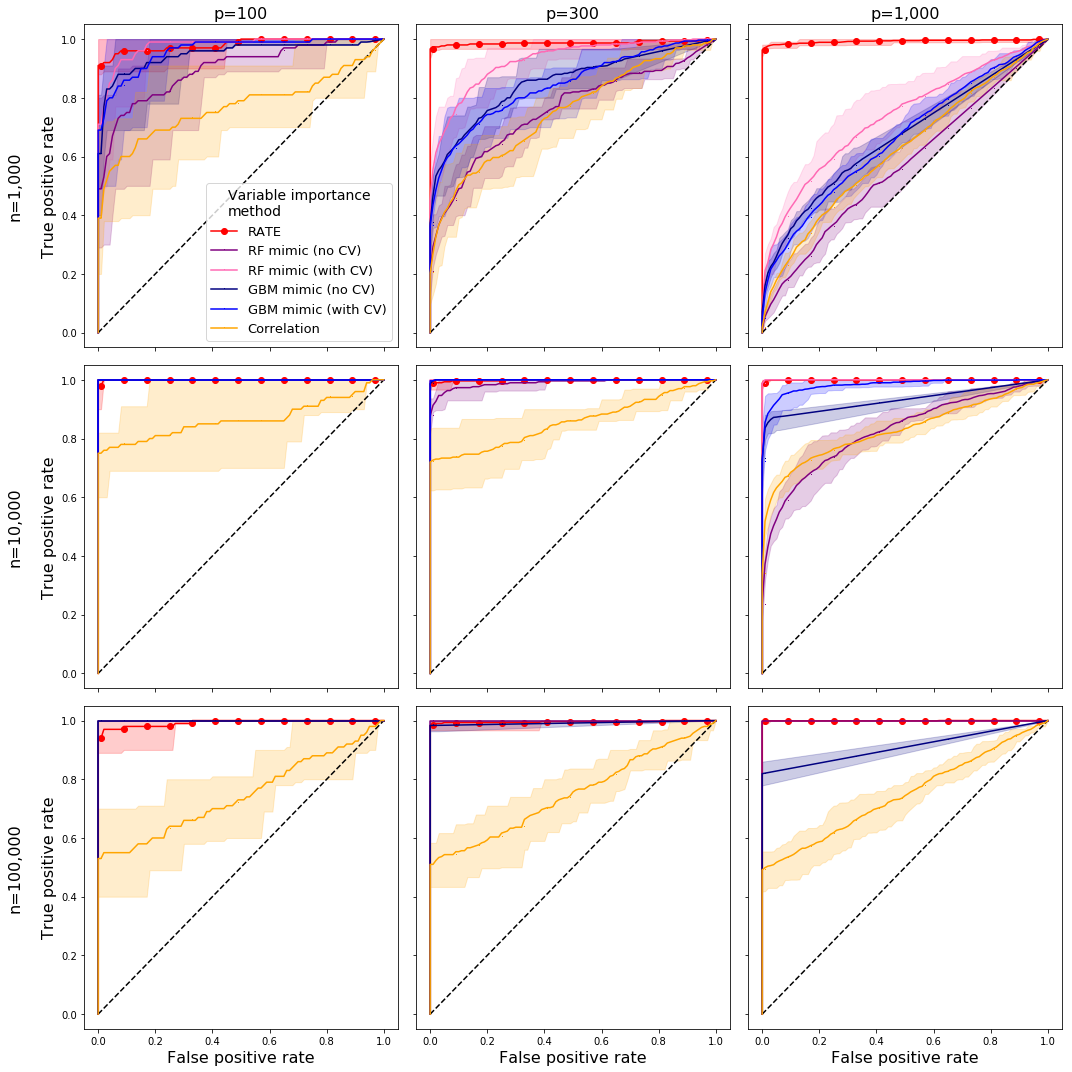

In [6]:
plotsize = 5
fontsize = 16

upper_qile, lower_qile = 0.9, 0.1
assert upper_qile+lower_qile == 1.0

included_methods = methods

fig, axes = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(3*plotsize, 3*plotsize))

for i, n in enumerate(n_vals):
    axes[i,0].set_ylabel("n={:,}\n\nTrue positive rate".format(n), fontsize=fontsize)
    for j, p in enumerate(p_vals):
        axes[0,j].set_title("p={:,}".format(p), fontsize=fontsize)
        axes[-1,j].set_xlabel("False positive rate", fontsize=fontsize)
        axes[i,j].plot([0,1], [0,1], c="black", linestyle="--")
        print("n=", n, "p=", p)
        p_informative = int(0.1*p)
        labels = np.hstack([np.ones(p_informative), np.zeros(p-p_informative)])
        for m in included_methods:
            k = (n,p)
            if m not in result_dict[k]:
                print("Skipping", m)
                continue
            curves, interp_tpr, aucs = [], [], []
            for rep in range(len(result_dict[k][m])):
                curves.append(roc_curve(labels, np.abs(result_dict[k][m][rep])))
                interp_tpr.append(np.interp(base_fpr, curves[-1][0], curves[-1][1]))
                aucs.append(auc(curves[-1][0], curves[-1][1]))
                
            interp_tpr = [np.hstack([[0.0], tpr]) for tpr in interp_tpr]
            mean_interp_tpr = np.mean(interp_tpr, axis=0)
            tpr_qile_upp = np.quantile(interp_tpr, upper_qile, axis=0)
            tpr_qile_low = np.quantile(interp_tpr, lower_qile, axis=0)

            axes[i,j].plot(np.hstack([[0], base_fpr]), mean_interp_tpr,
                c=colours[m],
                label=legend_labels[m])
            axes[i,j].plot(base_fpr[1::8], mean_interp_tpr[1::8], ls="",
                c=colours[m], marker=markers[m],
                label=legend_labels[m])
            
            axes[i,j].fill_between(np.hstack([[0], base_fpr]), tpr_qile_low, tpr_qile_upp,
                                   color=colours[m], alpha=ribbon_alpha)
            
            
# Legend
legend_elements = [Line2D([], [], c=colours[m], marker=markers[m],
                         label=legend_labels[m], alpha=1.0) for m in included_methods]

leg_title = "Variable importance\nmethod"
#borderpad = plt.rcParams["legend.borderpad"] if i==0 else 1.0
legend = axes[0,0].legend(handles=legend_elements, loc='lower right',
           ncol=1, fancybox=True, title=leg_title, 
               fontsize=fontsize-3)
legend.get_title().set_fontsize(fontsize-2)

plt.tight_layout()